#### Preliminaries

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
from scipy.stats import norm
plt.style.use('ggplot')

In [131]:
class GP_UCB(object):
    def __init__(self, init_X, X, Y_func, noise, beta):
        "Y is the true function"
        self.init_X = init_X.reshape(-1,1)
        self.init_Y = Y_func(init_X, noise=noise).reshape(-1,1)
        self.Y_func = Y_func
        self.X = X.reshape(-1,1)
        self.Y = Y_func(X, noise=noise).reshape(-1,1)
        self.Y_white = Y_func(X, noise=0)
        self.beta = beta
        self.k1 = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
        
        fig = plt.figure(figsize=(6.5,4.75), dpi=80)
        plt.scatter(self.init_X, self.init_Y, marker = 'X', s=100, c='black', label="Initial samples")
        plt.scatter(self.X, self.Y, marker = 'x', c='grey', alpha=0.65)
        plt.plot(self.X, self.Y_white, label = 'Original function', linewidth=1.5)
        plt.ylim(-10,30)
        plt.title('Real function')
        plt.legend()
        
        
    def af_gp_ucb(self, mean, variance, beta):
        return mean + np.sqrt(beta) * variance
              
    def _plot(self, sampling_point, gp_mean, gp_var):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        percentiles = self.model.predict_quantiles(self.X)
        # data used to plot the confidence interval
        percs = [p[:, 0] for p in percentiles]
        ax1.fill_between(X, percs[0], percs[1], facecolor='#3465a4', label='Confidence', alpha = 0.33)
        ax1.plot(X, self.Y_white, label = 'True function', linewidth=1.5, alpha=0.75)
        ax1.plot(X, gp_mean, label = 'Mean', linewidth=1.5, alpha=1, color='#204a87')
        ax1.scatter(self.init_X, self.init_Y, marker = 'X', s=50, c='black', label="Data samples")
        aq_ucb = self.af_gp_ucb(gp_mean, gp_var, self.beta)
        ax2.plot(self.X, aq_ucb, label="GP-UCB",c='green')
        y_llimit, y_ulimit = min(aq_ucb)-5, max(aq_ucb)+5
        ax2.vlines(sampling_point, y_llimit,y_ulimit, linestyle='dashed', \
                   color='black', label='Next sampling location')
        ax1.set_title('GP fitting')
        ax2.set_title('Aquisition Function')
        ax1.legend()
        ax2.legend()
        plt.ylim(y_llimit,y_ulimit)
        
    def one_iter(self):
        # Re-fiting the GP
        self.model = GPy.models.GPRegression(self.init_X, self.init_Y, self.k1, noise_var=1.)
        self.model.optimize(messages=False)
        self.model.optimize_restarts(0)
        # Sampling on the next location according to the aqu function
        gp_mean, gp_var = self.model.predict(self.X)
        aq_func = self.af_gp_ucb(gp_mean, gp_var, self.beta)
        #take the max of the aquisition function
        sampling_point = self.X[np.argmax(aq_func)]
        self._plot(sampling_point, gp_mean, gp_var)
        self.init_X = np.append(self.init_X , sampling_point[0]).reshape(-1,1)
        self.init_Y = np.append(self.init_Y, self.Y_func(sampling_point)).reshape(-1,1)
        if self.init_X[-1] == self.init_X[-2]:
            print("Convergence reached, optima of the function is at X={}".format(self.init_X[-1]))
        return self.init_X, self.init_Y

    def opt_routine(self):
        repeat = False
        while not repeat:
            self.one_iter()
            if self.init_X[-1] == self.init_X[-2]:
                repeat = True
        return print("Maximum of the function is at X={}".format(self.init_X[-1]))

In [449]:
def compare_af(x, y):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    distances = [abs(x[i+1] - x[i]) for i in range(len(x)-1)]
    print(distances)
    ax1.plot(np.arange(0, len(distances)), distances, marker='o')
    ax2.plot(np.arange(0, len(y)), y, marker='o', c='g')
    
    ax1.set_title('Distance between consecutive sampled points')
    ax2.set_title('Value of best selected sample')
    ax1.set_xlabel("Sample #")
    ax1.set_ylabel("Distance")
    ax2.set_xlabel("Sample #")
    ax2.set_ylabel("Value")

---

### BO Recap
Bayesian Optimization (BO) can be used to find the minimum of an expensive function or to find the best hyperparameters of our ML model. 

We avoid optimizing the original (*expensive*) function by modelling it with a probabilistic model (e.g. GPs).

Equipped with this probabilistic model, que are now well positioned to introduce aquisition functions, constructions that let us leverage their uncertainty to balance exploration and exploitation.

In that sense, aquisition functions have 2 objectives at any given time:
    
    - Reduce uncertainty (explore)
    - Find the optimum of the original function (exploit)
    
Different aquisition functions trade them differently and is our job to manage this balance as needed. 
Concretely, the general Bayesian Optimization algorithm is the following:

-------------
1.    **for** n=1,2,....**do**
2.  select new $x_{n+1}$ by optimizing aquisition function $\alpha$ 

    $x_{n_+1}$ $\arg \max_{x} \alpha (x; \mathcal{D}_n)$ 


3. query objective function to obtain $y_{n+1}$
4. augment data $\mathcal{D}_{n+1}$ = $D_n, (x_{n+1}, y_{n+1})$
5. update statistical model (new prior)
6. **end for**
----------------

Just like other Machine Learning algorithms, we need to know how good we are doing with a loss function, in Bayesian Optimization, it takes the form of *regret* and we want it to a minimum.

### Motivation
Let's start with a motivating example.

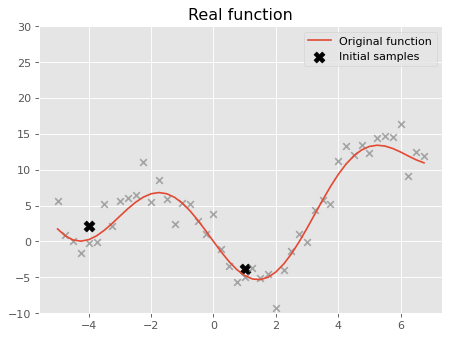

In [135]:
def func(X, noise=0):
    return (0.3 * X ** 2 - 6 * np.sin(X) + noise * np.random.randn(*X.shape))

noise = 2
init_X = np.array([-4,1])
X = np.arange(-5,7,0.25)


Y = func(X, noise)
Y_white = func(X)
init_Y = func(init_X, noise)
beta = 1

BO1 = GP_UCB(init_X, X, func, noise, beta)

##### Running one iteration at the time
*(Don't forget to re-instansiate the `GP_UCB` object in the above cell)*

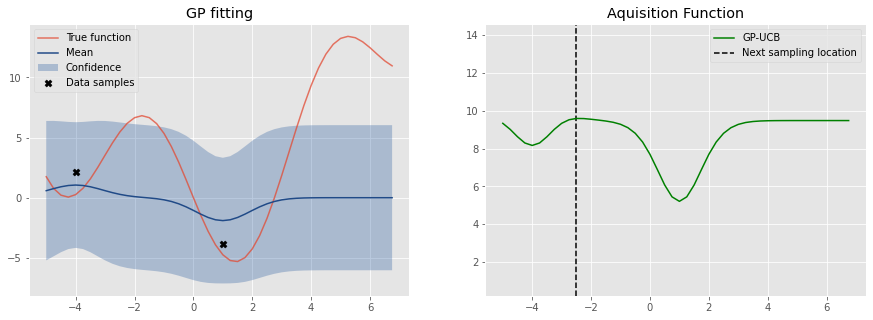

In [136]:
#Run me until convergence
_, _ = BO1.one_iter()

##### Running a complete optimization routine

Convergence reached, optima of the function is at X=[5.5]
Maximum of the function is at X=[5.5]


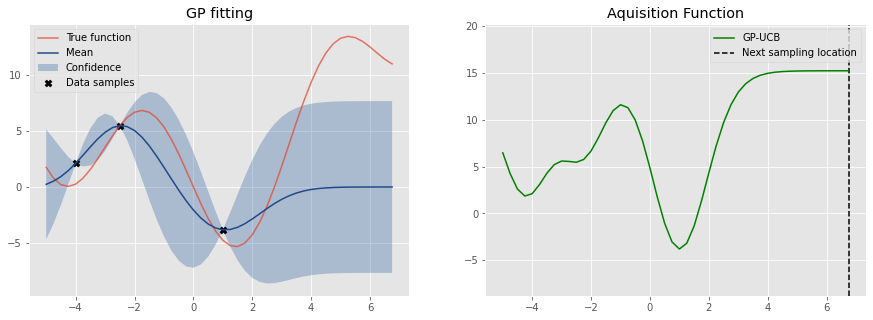

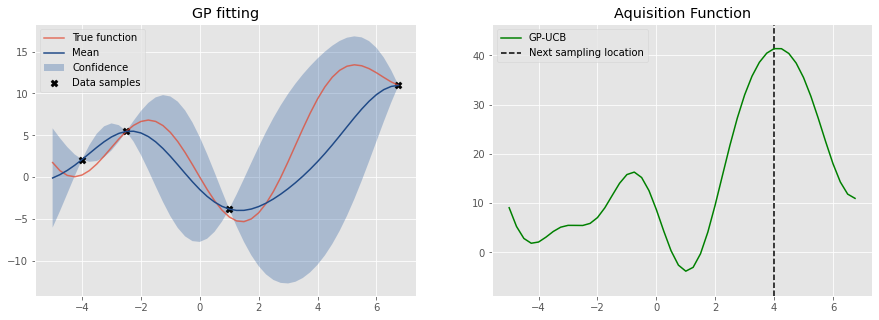

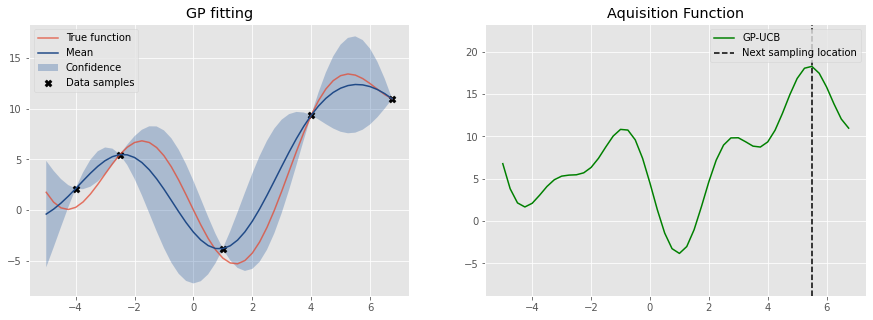

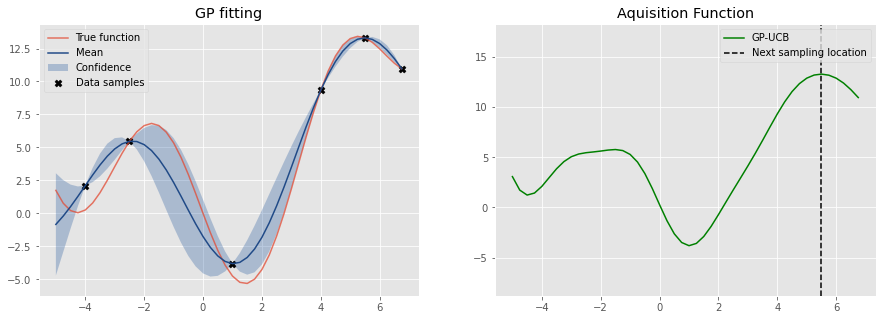

In [137]:
BO1.opt_routine()

### Hands on!

In the following exercise, we'll dive more into the details of two acquisition functions and then we will see optimization routines using them

##### Talking 
*-I designed this tutorial to be self contained, so that you guys come back whenever you want to and not need to look for somethign you dont' remember elsewhere-*

##### Gaussian Process - Upper Confidence Bound (GP-UCB)

As we know, Gaussian Processes (GPs) are probabilistic functions, but a major advantage of working with them is the existence of simple analytic formulae for mean and covariance of the posterior distribution, which allows
easy implementation of algorithms. (Srinivas, 2010)

```
*Think of fitting a GP to the function we want to optimize, and then optimizing that GP. You remember that in GP, we have a mean and we have the confidence bounds above and below the mean function. Say we are in a maximization function, in UCB, we would try to maximize the UCB (of course) **not** the mean function.*
```




###### Equation:
$$ x_{t} = \arg \max_{x \in C } \mu_{t-1}(x) + \sqrt{ \beta_{t}} \sigma_{t-1}(x)  $$

This equation inplicitly negotiates the exploration–exploitation tradeof. Let's say we only had the exploitation section, i.e.

$$ x_{t} = \arg \max_{x \in C } \mu_{t-1}(x)  $$

In that case, we would get stuck in local minima very quicky, but by introducing the exploration part, we can use the $\beta$ constant to control the degree of exploration in the optimization; providing us with a much more powerful behavior.
In the figure [1] can be seen how this algorithm first explores (b) and then exploits (c).

<center><img src = "https://drive.google.com/uc?id=1WT85ZShVc-Ze6hdI0M2xylDFJBNOE3Ot" width="440" height="440"></center>
Figure 1. (Srinivas, 2019)

##### Building a mini BO framework
Now we are going to build a mini framework to do Bayesian Optimization

In [367]:
class bayes_opt(object):
    def __init__(self, X, true_func, aquisition_function, **kwargs):
        """
        param x: X space over which the optimization will be computed
        param true_func: function ought to be fitted
        param aquisition_function: aquisition function
        param noise: sampling variance
        """
        self.X = X.reshape(-1,1)                                #Reshaping due to GPy requirements
        self.true_func = true_func
        self.aquisition_function = aquisition_function
        for k, v in kwargs.items():
            setattr(self, k, v)
        self.noise = 2
        self.kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
        
        #Un-comment to randomly select two initial points
        #self.init_X = np.random.choice(self.X.reshape(-1,), (2,1))  
        self.init_X = np.array([-4,1]).reshape(-1,1)
        self.init_Y = self.true_func(self.init_X).reshape(-1,1)
        self.Y = self.true_func(self.X, noise=self.noise).reshape(-1,1)
        self.Y_white= self.true_func(self.X, noise=0).reshape(-1,1)
        
        self.opt_value = []
        
        #initial plots 
        #@TODO: Refactor this
        
        fig = plt.figure(figsize=(6.5,4.75), dpi=80)
        plt.scatter(self.init_X, self.init_Y, marker = 'X', s=100, c='black', label="Initial samples")
        plt.scatter(self.X, self.Y, marker = 'x', c='grey', alpha=0.65)
        plt.plot(self.X, self.Y_white, label = 'True function', linewidth=1.5)
        plt.ylim(-10,30)
        plt.title('Initial State')
        plt.legend()

        
    
    def _reinit_kernel(self):
        """Re-instanciate kernel, otherwise GPy starts acting weird"""
        if self.isgp:
            self.kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
    
    def step(self):
        "computes one iteration of optimization the algoritm [1]"
        # Re-fiting the GP
        self.model = GPy.models.GPRegression(self.init_X, self.init_Y, self.kernel, noise_var=1.)
        self.model.optimize(messages=False)
        self.model.optimize_restarts(0)
        # Sampling on the next location according to the aq. function
        gp_mean, gp_var = self.model.predict(self.X)
        # Note that gp_mean has the same dimensions as self.X
        if hasattr(self, 'beta'):
            aq_func = self.aquisition_function(mean=gp_mean, variance=gp_var, beta=self.beta)
        if hasattr(self, 'alpha'):
            aq_func = self.aquisition_function(mean=gp_mean, variance=gp_var, alpha=self.alpha)
        # Take the max-index of the aquisition function for re-sampling in the next-iteration
        sampling_point = self.X[np.argmax(aq_func)]
        self._plot(sampling_point, gp_mean, gp_var)
        self.init_X = np.append(self.init_X , sampling_point[0]).reshape(-1,1)
        self.init_Y = np.append(self.init_Y, self.true_func(sampling_point)).reshape(-1,1)
        if self.init_X[-1] == self.init_X[-2]:
            print("Convergence reached, optimum of the function is at X={}".format(self.init_X[-1]))
        return self.init_X, self.init_Y
    
    def optimize(self):
        """
        Runs the algorithm [1] until convergence.
        Convergence criteria: if the algorithm samples the same location twice
        """
        self._reinit_kernel()
        # flag that indicates convergence
        repeat = False                   
        while not repeat:
            self.one_iter()
            # convergence criteria. Naive but will work with these basic true functions
            if self.init_X[-1] == self.init_X[-2]:
                repeat = True
        return print("Optimum of the function is at X={}".format(self.init_X[-1]))
    
    def _plot(self, sampling_point, gp_mean, gp_var):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        percentiles = self.model.predict_quantiles(self.X)
        # data used to plot the confidence interval
        percs = [p[:, 0] for p in percentiles]
        ax1.fill_between(X, percs[0], percs[1], facecolor='#3465a4', label='Confidence', alpha = 0.33)
        ax1.plot(X, self.Y_white, label = 'True function', linewidth=1.5, alpha=0.75)
        ax1.plot(X, gp_mean, label = 'Mean', linewidth=1.5, alpha=1, color='#204a87')
        ax1.scatter(self.init_X, self.init_Y, marker = 'X', s=50, c='black', label="Data samples")
        if hasattr(self, 'beta'):
            aq_func = self.aquisition_function(mean=gp_mean, variance=gp_var, beta=self.beta)
        if hasattr(self, 'alpha'):
            aq_func = self.aquisition_function(gp_mean, gp_var, self.opt_value, self.alpha)
        ax2.plot(self.X, aq_func, label="GP-UCB",c='green')
        y_llimit, y_ulimit = min(aq_func), max(aq_func)
        ax2.vlines(sampling_point, y_llimit,y_ulimit, linestyle='dashed', \
                   color='black', label='Next sampling location')
        ax1.set_title('GP fitting')
        ax2.set_title('Aquisition Function')
        ax1.legend()
        ax2.legend()
        #plt.ylim(y_llimit,y_ulimit) 
    

In [368]:
def func(X, noise=0):
    return (0.3 * X ** 2 - 6 * np.sin(X) + noise * np.random.randn(*X.shape))

#cambiar funcion
X = np.arange(-5,7,0.2)

### Define the GP-UCP aquisition function
Define the UCB constant as `beta` 
<blockquote>(In this part of the exercise the participants will have to 'fill in the blanks' to complete the function)</blockquote>

In [403]:
#code this cell
def gp_ucb(mean, variance, opt_value=None, beta=0.0):
    return mean + np.sqrt(beta) * variance

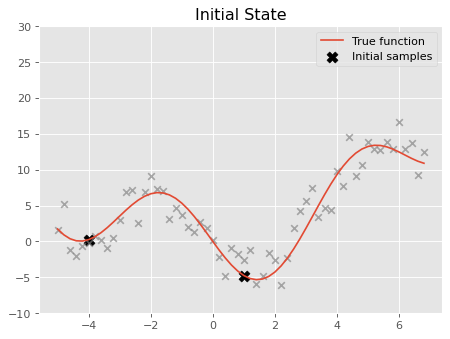

In [404]:
BO_UCB = bayes_opt(X, func, gp_ucb, beta=1)

##### Try your implementation: 
*Run this cell several times until convergence (instansiate the object again if you want to start over)*
*stop when you get a message of convergence reached"

Convergence reached, optimum of the function is at X=[5.2]


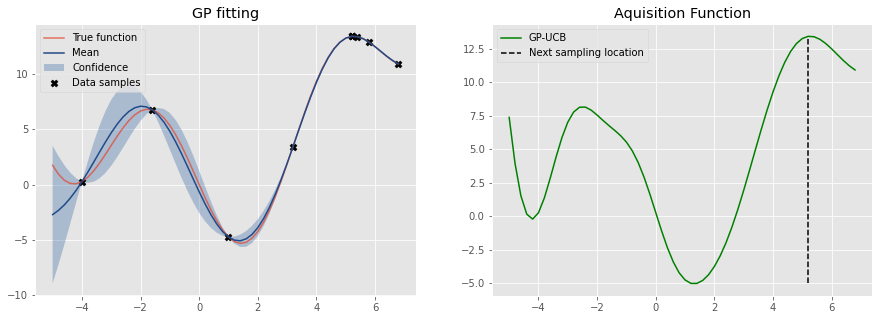

In [438]:
x_ucb,y_ucb = BO_UCB.step()

### Define Expected Improvement (EI) Aquisition Function

Expected improvement is another aquisition function

`alpha` is the Expected Improvement constant
<blockquote>Fill in the blanks</blockquote>

In [413]:
def expected_improvement(mean, variance, opt_value=None, alpha=1.):
    """ Returns the expected improvement at query point x."""
    gamma_x = (mean - variance - beta) / variance
    return variance * (gamma_x * norm.cdf(gamma_x) + norm.pdf(gamma_x))

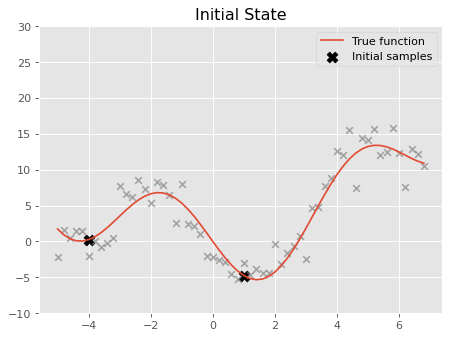

In [416]:
BO_EI = bayes_opt(X, func, expected_improvement, alpha=0)

Convergence reached, optimum of the function is at X=[5.6]


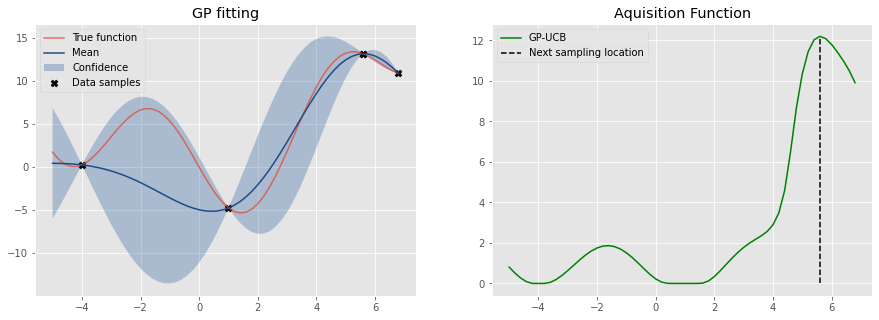

In [433]:
x_ei, y_ei = BO_EI.step()

In [434]:
y_ei

array([[ 0.25918503],
       [-4.74882591],
       [10.90731989],
       [13.19559983],
       [13.19559983],
       [13.19559983]])

### Performance of the Aquisition Functions

In the next section we will compare the performance the AF in terms of how much they encourage exploration and in terms of the number of iterations needed to reach the optima.

#### GP-UCB

[array([5.]), array([5.8]), array([1.6]), array([6.8]), array([4.8]), array([2.6]), array([0.4]), array([0.2]), array([0.])]


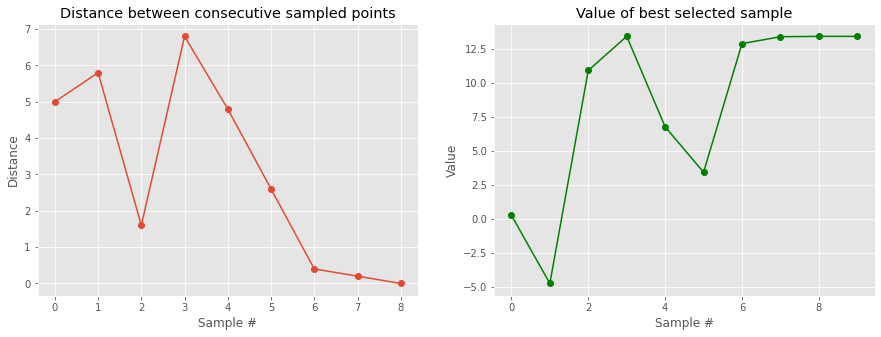

In [436]:
compare_af(x_ucb, y_ucb)

#### Expected Improvement

[array([5.]), array([5.8]), array([1.2]), array([0.]), array([0.])]


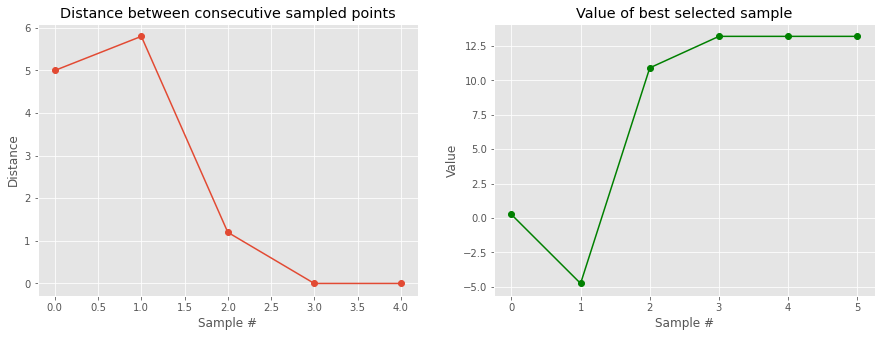

In [437]:
compare_af(x_ei, y_ei)

#### Sensitivity analysis

1. What if we change the initial samples?
    - Will EI be the fastest again?
2. What would happen if we change the hyperparameters of the aquisition function?
    - Can we make the convergence faster?

#### Bonus
- Can you implement another AF?
   - Try searching for "Probability of Improvement"

## References

1. [Srinivas, 2019](https://arxiv.org/pdf/0912.3995.pdf) 
2. [Shahriari, 2015](https://drive.google.com/viewerng/viewer?url=https://www.cs.ox.ac.uk/people/nando.defreitas/publications/BayesOptLoop.pdf)